# Generating Distributed MeasurementSets from a Deconvolved Image  

This notebook proposes an easy-to-use method to generate distributed **MeasurementSets (MS)** from a deconvolved **FITS** (Flexible Image Transport System) image.  

## Goal  

Our final goal is to generate multiple **MS** files from a single **FITS** image. These files will be distributed across multiple architecture nodes (e.g., multicore CPUs, GPU-accelerated systems, etc.) and processed in a pipeline.  

## Possible Approaches  

One possibility is to process a spectral cube:  

<p align="center">
  <img src="https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/7712e396f0309a7d9309a77cfa8fc6fc2f8a0be9.png?raw=1" width="500">
</p>  

Or, we could treat the image as a continuum:  

<p align="center">
  <img src="https://github.com/casangi/casadocs/blob/master/docs/notebooks/media/51885b785409ea1448f61c399eb82e53f0a54729.png?raw=1" width="500">
</p>  

## Method steps

1. Read a **FITS** `.fits` image or configure a multispectral one.
2. Employ a degridding method (either RASCIL, DDFACET, G2G ...)
3. Build distributed **MeasurementSets** `.ms`from extrated visibilities
4. Test an validate the **MeasurementSets**

 

In [1]:
# Install
!pip install --upgrade xarray
!pip install astropy opencv-python scikit-image

In [2]:
# Imports
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Ajout pour éviter l'erreur
import os
import numpy as np
from astropy.io import fits
import scipy.ndimage

!pip show ska-sdp-datamodels
#replace by your path
import sys
sys.path.append('/home/orenaud/miniconda3/lib/python3.12/site-packages')
from ska_sdp_datamodels.configuration import create_named_configuration
from astropy.coordinates import SkyCoord
from astropy import units as u
from ska_sdp_datamodels.configuration import create_named_configuration
from ska_sdp_datamodels.visibility import create_visibility
from ska_sdp_datamodels.science_data_model.polarisation_model import PolarisationFrame
from ska_sdp_func_python.imaging import invert_ng, predict_ng, \
     create_image_from_visibility, advise_wide_field 
from ska_sdp_datamodels.image import Image
from astropy.wcs import WCS
import logging
import warnings


['.ipynb_checkpoints', 'spectral_fits', 'spectral_ms', 'distributed_ms_from_fits_rascil.ipynb', 'RP1C_transit.py']
Name: ska-sdp-datamodels
Version: 1.0.0
Summary: SKA SDP Python-based Data Models
Home-page: 
Author: SKA SDP Developers
Author-email: 
License: Apache 2.0
Location: /home/orenaud/miniconda3/lib/python3.12/site-packages
Requires: astroplan, astropy, h5py, msgpack, msgpack-numpy, numpy, pandas, ska-telmodel, xarray
Required-by: ska-sdp-func-python


/usr/lib/python3.12/abc.py:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


## 1. FITS

#### Read image  

We start from a `.fits` image, a widely used portable file standard in the astronomy community for storing images and tables. 

/home/orenaud/Documents/GITHUB/VIS/vis-generator/skao_lib_simulator


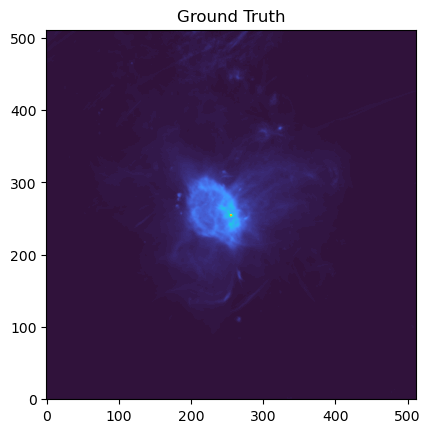

In [6]:

def readFits(filename):
    dat = fits.open(filename)[0].data
    while len(dat.shape) > 2:
        dat = dat[0]

    return dat

def plotNImages(images, names, cmap, same_scale=False, scale_mul=1.0, output_file=None, additional_scale_imgs=None, hide_ticks=False, colorbar_location="bottom", cbar_labelsize=None, logNorm=False, vpadding=0):
    num_images = len(images)

    fig, axes = plt.subplots(1, num_images)

    im = None

    vmin = 999999999999
    vmax = -999999999999

    if same_scale:
        for img in images:
            vmin = min(vmin, numpy.min(img))
            vmax = max(vmax, numpy.max(img))
        if additional_scale_imgs is not None:
            for img in additional_scale_imgs:
                vmin = min(vmin, numpy.min(img))
                vmax = max(vmax, numpy.max(img))

    vmin *= scale_mul
    vmax *= scale_mul
    vmin -= vpadding
    vmax += vpadding



    for i, img in enumerate(images):
        while(len(img.shape) > 2):
            img = img[0]

        if num_images > 1:
            axes[i].set_title(names[i])
            if same_scale:
                im = axes[i].imshow(img, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
            else:
                im = axes[i].imshow(img, cmap=cmap, origin='lower')

            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes(colorbar_location, size="5%", pad=0.25)

            cb = fig.colorbar(im, orientation='horizontal', cax=cax)
            #cb.formatter.set_powerlimits((-10, 10))
            cb.ax.locator_params(nbins=5)
            if cbar_labelsize is not None:
                cb.ax.tick_params(labelsize=cbar_labelsize)
        else:
            axes.set_title(names[i])
            if same_scale:
                im = axes.imshow(img, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
            else:
                im = axes.imshow(img, cmap=cmap, origin='lower')

    if hide_ticks:
        axes.set_xticks([])
        axes.set_yticks([])


    if output_file is not None:
        plt.savefig(output_file, pad_inches=0.0, bbox_inches='tight')
    else:
        plt.show()


current_directory = os.getcwd()
print(current_directory)
os.chdir("..")
gt_name = "example/SGRA_full_gt.fits"

gt_hdu = fits.open(gt_name)[0]
gt = readFits(gt_name)
npix = np.max(gt.shape)

plotNImages([gt], ["Ground Truth"], cmap='turbo')

#### Generate custom fits

At some point it should be a good idea to generate our custom **FITS** image where we can tune frequency and other parameters.

In [7]:
# TODO: import generator.pyds9 *.fits -lock frame wcs -zoom to fit

#### Generate a cube from fits

Fichier enregistré : skao_lib_simulator/spectral_fits/image_1.40MHz.fits avec filtre highpass
Fichier enregistré : skao_lib_simulator/spectral_fits/image_1.50MHz.fits avec filtre lowpass
Fichier enregistré : skao_lib_simulator/spectral_fits/image_1.60MHz.fits avec filtre highpass
Fichier enregistré : skao_lib_simulator/spectral_fits/image_1.70MHz.fits avec filtre highpass
Fichier enregistré : skao_lib_simulator/spectral_fits/image_1.80MHz.fits avec filtre lowpass
Fichier enregistré : skao_lib_simulator/spectral_fits/image_1.90MHz.fits avec filtre lowpass
Fichier enregistré : skao_lib_simulator/spectral_fits/image_2.00MHz.fits avec filtre lowpass
Fichier enregistré : skao_lib_simulator/spectral_fits/image_2.10MHz.fits avec filtre lowpass
Fichier enregistré : skao_lib_simulator/spectral_fits/image_2.20MHz.fits avec filtre lowpass
Fichier enregistré : skao_lib_simulator/spectral_fits/image_2.30MHz.fits avec filtre lowpass


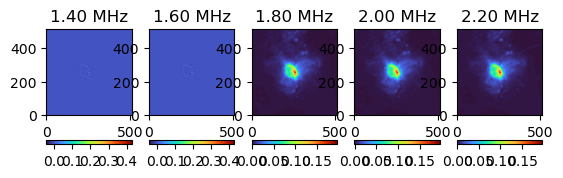

In [12]:


def apply_random_filter(image_2d, filter_type='lowpass'):
    """Applique un filtre passe-bas ou passe-haut de manière aléatoire sur l'image."""
    if filter_type == 'lowpass':
        # Appliquer un filtre passe-bas avec un noyau gaussien
        return scipy.ndimage.gaussian_filter(image_2d, sigma=3)
    elif filter_type == 'highpass':
        # Appliquer un filtre passe-haut en soustrayant le filtre passe-bas
        lowpass = scipy.ndimage.gaussian_filter(image_2d, sigma=3)
        return image_2d - lowpass
    else:
        return image_2d  # Aucune modification si le filtre n'est pas reconnu


def generate_spectral_cube(base_fits, output_dir="spectral_fits", num_freqs=10, freq_start=1.0, freq_step=0.1, alpha=-0.7):    

    """Génère un cube FITS à partir d'une image 2D en simulant plusieurs fréquences."""
    
    # Lire l'image FITS 2D
    hdulist = fits.open(base_fits)
    image_2d = hdulist[0].data
    header = hdulist[0].header
    hdulist.close()

    # Vérifier la forme de l'image
    while len(image_2d.shape) > 2:
        image_2d = image_2d[0]  # Extraire la première couche si nécessaire

     # Générer les fréquences
    freqs = np.array([freq_start + i * freq_step for i in range(num_freqs)])
    
    # Créer un dossier pour les fichiers FITS
    os.makedirs(output_dir, exist_ok=True)

    
    for i, freq in enumerate(freqs):
        # Appliquer un filtre aléatoire pour chaque fréquence
        filter_type = np.random.choice(['lowpass', 'highpass'])
        processed_image = apply_random_filter(image_2d, filter_type=filter_type)
        # Sauvegarder chaque fréquence dans un fichier FITS distinct
        output_filename = os.path.join(output_dir, f"image_{freq:.2f}MHz.fits")
        fits.writeto(output_filename, processed_image, header, overwrite=True)
        print(f"Fichier enregistré : {output_filename} avec filtre {filter_type}")

output_folder = "skao_lib_simulator/spectral_fits"
os.system(f"rm -rf {output_folder}/*")        
    
# 🔹 Génération des images spectrales
generate_spectral_cube("example/SGRA_full_gt.fits", output_dir="skao_lib_simulator/spectral_fits", num_freqs=10, freq_start=1.4, freq_step=0.1, alpha=-0.5)

# 🔹 Charger plusieurs images de 1.40 MHz à 2.30 MHz
freqs = np.arange(1.40, 2.40, 0.20)  # 1.40 → 2.30 MHz par pas de 0.10

images = []
titles = []

for freq in freqs:
    filename = f"skao_lib_simulator/spectral_fits/image_{freq:.2f}MHz.fits"
    if os.path.exists(filename):
        images.append(readFits(filename))
        titles.append(f"{freq:.2f} MHz")

# 🔹 Afficher toutes les images en une seule figure
plotNImages(images, titles, cmap="turbo")

Check the generated fits from the spectral_fits/ repository:
Open a terminal

Install ds9: `sudo apt install saods9`

Run:`ds9 *.fits -lock frame wcs -zoom to fit`


---
## 2. Degridding

As the purpose is to generate visibilities from image we apply the RASCIL degridding to "gt_name" a.k.a the fits image.

Possible configurations are:

        LOWBD2
        LOWBD2-CORE (Core 166 antennas)
        LOW == LOWR4 (LOWR3 still available)
        LOW-AA0.5
        MID == MIDR5
        MID-AA0.5
        MEERKAT+
        ASKAP
        LOFAR
        VLAA
        VLAA_north


In [14]:

warnings.filterwarnings('ignore', category=FutureWarning)



log = logging.getLogger("rascil-logger")


def replicate_image(
    im: Image,
    polarisation_frame=PolarisationFrame("stokesI"),
    frequency=np.array([1e8]),
) -> Image:
    """Make a new canonical shape Image, extended along third and fourth axes
    by replication.

    The order of the data is [chan, pol, dec, ra]


    :param frequency:
    :param im:
    :param polarisation_frame: Polarisation_frame
    :return: Image
    """

    newwcs = WCS(naxis=4)

    newwcs.wcs.crpix = [
        im.image_acc.wcs.wcs.crpix[0] + 1.0,
        im.image_acc.wcs.wcs.crpix[1] + 1.0,
        1.0,
        1.0,
    ]
    newwcs.wcs.cdelt = [
        im.image_acc.wcs.wcs.cdelt[0],
        im.image_acc.wcs.wcs.cdelt[1],
        1.0,
        1.0,
    ]
    newwcs.wcs.crval = [
        im.image_acc.wcs.wcs.crval[0],
        im.image_acc.wcs.wcs.crval[1],
        1.0,
        frequency[0],
    ]
    newwcs.wcs.ctype = [
        im.image_acc.wcs.wcs.ctype[0],
        im.image_acc.wcs.wcs.ctype[1],
        "STOKES",
        "FREQ",
    ]

    nchan = len(frequency)
    npol = polarisation_frame.npol

    fshape = [nchan, npol, im["pixels"].data.shape[-2], im["pixels"].data.shape[-1]]
    data = np.zeros(fshape)
    log.info(
        "replicate_image: replicating shape %s to %s"
        % (im["pixels"].data.shape, data.shape)
    )
    if len(im["pixels"].data.shape) == 2:
        data[...] = im["pixels"].data[np.newaxis, np.newaxis, ...]
    else:
        for pol in range(npol):
            data[:, pol] = im["pixels"][:, 0]

    return Image.constructor(
        data=data, polarisation_frame=polarisation_frame, wcs=newwcs
    )



def polarisation_frame_from_wcs(wcs, shape) -> PolarisationFrame:
    """Convert wcs to polarisation_frame

    See FITS definition in Table 29 of https://fits.gsfc.nasa.gov/standard40/fits_standard40draft1.pdf
    or subsequent revision

        1 I Standard Stokes unpolarized
        2 Q Standard Stokes linear
        3 U Standard Stokes linear
        4 V Standard Stokes circular
        −1 RR Right-right circular
        −2 LL Left-left circular
        −3 RL Right-left cross-circular
        −4 LR Left-right cross-circular
        −5 XX X parallel linear
        −6 YY Y parallel linear
        −7 XY XY cross linear
        −8 YX YX cross linear

        stokesI [1]
        stokesIQUV [1,2,3,4]
        circular [-1,-2,-3,-4]
        linear [-5,-6,-7,-8]

    For example::
        pol_frame = polarisation_frame_from_wcs(im.image_acc.wcs, im["pixels"].data.shape)


    :param wcs: World Coordinate System
    :param shape: Shape corresponding to wcs
    :returns: Polarisation_Frame object
    """
    # The third axis should be stokes:

    polarisation_frame = None

    if len(shape) == 2:
        polarisation_frame = PolarisationFrame("stokesI")
    else:
        npol = shape[1]
        pol = wcs.sub(["stokes"]).wcs_pix2world(range(npol), 0)[0]
        pol = np.array(pol, dtype="int")
        for key in PolarisationFrame.fits_codes.keys():
            keypol = np.array(PolarisationFrame.fits_codes[key])
            if np.array_equal(pol, keypol):
                polarisation_frame = PolarisationFrame(key)
                return polarisation_frame
    if polarisation_frame is None:
        raise ValueError("Cannot determine polarisation code")

    # assert isinstance(polarisation_frame, PolarisationFrame)
    return polarisation_frame

def import_image_from_fits(fitsfile: str, fixpol=True) -> Image:
    """Read an Image from fits

    :param fitsfile: FITS file in storage
    :return: Image
    """
    #warnings.simplefilter("ignore", FITSFixedWarning)
    hdulist = fits.open(fitsfile)
    data = hdulist[0].data
    header = hdulist[0].header
    try:
        bmaj = header.cards["BMAJ"].value
        bmin = header.cards["BMIN"].value
        bpa = header.cards["BPA"].value
        clean_beam = {"bmaj": bmaj, "bmin": bmin, "bpa": bpa}
    except KeyError:
        clean_beam = None

    wcs = WCS(fitsfile)
    hdulist.close()

    polarisation_frame = PolarisationFrame("stokesI")

    if len(data.shape) == 4:
        # RASCIL images are RA, DEC, STOKES, FREQ
        if wcs.axis_type_names[3] == "STOKES" or wcs.axis_type_names[2] == "FREQ":
            wcs = wcs.swapaxes(2, 3)
            data = np.transpose(data, (1, 0, 2, 3))
        try:
            polarisation_frame = polarisation_frame_from_wcs(wcs, data.shape)
            # FITS and RASCIL polarisation conventions differ
            if fixpol:
                permute = polarisation_frame.fits_to_datamodels[polarisation_frame.type]
                newim_data = data.copy()
                for ip, p in enumerate(permute):
                    newim_data[:, p, ...] = data[:, ip, ...]
                data = newim_data

        except ValueError:
            polarisation_frame = PolarisationFrame("stokesI")

    elif len(data.shape) == 2:
        ny, nx = data.shape
        data.reshape([1, 1, ny, nx])

    log.debug(
        "import_image_from_fits: created %s image of shape %s"
        % (data.dtype, str(data.shape))
    )
    log.debug(
        "import_image_from_fits: Max, min in %s = %.6f, %.6f"
        % (fitsfile, data.max(), data.min())
    )
    print(f"Shape des données FITS importées: {data.shape}")
    print(f"Polarisation attendue: {polarisation_frame.names}")

    return Image.constructor(
        data=data, polarisation_frame=polarisation_frame, wcs=wcs, clean_beam=clean_beam
    )
    
#creer la structure des visbilité mais touche pas au visibilité
def generate_visibilities(phasecentre, ha_interval, integration_time=120., tel='LOFAR',
                          rmax=None, frequencies=None, channel_bandwidths=None, elevation_limit=None):
    '''
    This routine will use rascil tools to create a visibility structure, for observations taken from a given telescope, in the
    direction of a (SkyCoord) phase_center.
    By default times are expressed as HA in radians. 
    frequencies: array of values in Hz. If frequencies is not specified, a single value of 1e9 Hz is assumed.
    channel_bandwidths: array of values in Hz. If not specified, a single value of 1e6 Hz is assumed.
    '''
    
    if not isinstance(phasecentre, SkyCoord):
        print("phasecentre should be a SkyCoord instance")
        return
    
    config = create_named_configuration(tel, rmax=rmax)
    print(config)  # Correction : bien aligné avec la définition de la fonction
    
    if frequencies is None:
        frequencies = np.array([1.e9])
    if channel_bandwidths is None:
        channel_bandwidths = np.array([1.e6])

    # Now compute number of integration times and corresponding HAs
    dtime_hr = integration_time / 3600.
    ntimes = int((ha_interval[1] - ha_interval[0]) / dtime_hr)
    # Centered w.r.t. transit, in radian
    times = np.linspace(ha_interval[0] + dtime_hr / 2., ha_interval[1] - dtime_hr / 2., ntimes) * np.pi / 12.0 
    vt = create_visibility(config, times, frequencies, channel_bandwidth=channel_bandwidths, 
                           weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'),
                           elevation_limit=elevation_limit)

    return vt


def visibilities_from_image(vt,fitsfile,scale_factor=1.0,return_cellsize=True, return_image=False, override_cellsize=False, ocellsize=1):
	'''
	Load an image from fits file, and create an Image structure, with 
	corresponding wcs info
	'''
	advice = advise_wide_field(vt, guard_band_image=3.0, delA=0.1, facets=1, 
		oversampling_synthesised_beam=4.0)
	cellsize = ocellsize if override_cellsize else scale_factor*advice['cellsize']

	im = create_image_from_fits(fitsfile,frequency=vt.frequency.data,cellsize=cellsize,phasecentre=vt.phasecentre)
	ivt = predict_ng(vt,im,context='2d')
	if return_cellsize and return_image:
		return(ivt,cellsize,im)
	elif (return_cellsize and not return_image):
		return(ivt,cellsize)
	elif (return_image and not return_cellsize):
		return(ivt,im)
	else:
		return(ivt)
    
# Almost cut and paste from create_test_image (rascil library)
def create_image_from_fits(
    fitsfile,
    cellsize=None,
    frequency=None,
    channel_bandwidth=None,
    phasecentre=None,
    polarisation_frame=None,
) -> Image:
    """Create a useful test image

    This is the test image M31 widely used in ALMA and other simulations. It is actually part of an Halpha region in
    M31.

    :param fitsfile: Input image FITS file
    :param cellsize: pixel size in dg
    :param frequency: Frequency (array) in Hz
    :param channel_bandwidth: Channel bandwidth (array) in Hz
    :param phasecentre: Phase centre of image (SkyCoord)
    :param polarisation_frame: Polarisation frame
    :return: Image
    """
    

    if not os.path.exists(fitsfile):
        print ("Input FITS file %s does not exist, exiting."%fitsfile)
        return None

    im = import_image_from_fits(fitsfile)
    

    if frequency is None:
        frequency = [1e8]
    if polarisation_frame is None:
        polarisation_frame = im.image_acc.polarisation_frame
    im = replicate_image(im, frequency=frequency, polarisation_frame=polarisation_frame)

    wcs = im.image_acc.wcs.deepcopy()

    if cellsize is not None:
        wcs.wcs.cdelt[0] = -180.0 * cellsize / np.pi
        wcs.wcs.cdelt[1] = +180.0 * cellsize / np.pi
    if frequency is not None:
        wcs.wcs.crval[3] = frequency[0]
    if channel_bandwidth is not None:
        wcs.wcs.cdelt[3] = channel_bandwidth[0]
    else:
        if len(frequency) > 1:
            wcs.wcs.cdelt[3] = frequency[1] - frequency[0]
        else:
            wcs.wcs.cdelt[3] = 0.001 * frequency[0]
    wcs.wcs.radesys = "ICRS"
    wcs.wcs.equinox = 2000.00

    if phasecentre is None:
        phasecentre = im.image_acc.phasecentre
    else:
        wcs.wcs.crval[0] = phasecentre.ra.deg
        wcs.wcs.crval[1] = phasecentre.dec.deg
        # WCS is 1 relative
        wcs.wcs.crpix[0] = im["pixels"].data.shape[3] // 2 + 1
        wcs.wcs.crpix[1] = im["pixels"].data.shape[2] // 2 + 1

    
    return Image.constructor(
        im["pixels"].data, wcs=wcs, polarisation_frame=polarisation_frame
    )


# Paramètres
phasecentre = SkyCoord(ra=+56.0 * u.deg, dec=-30.0 * u.deg, frame='icrs', equinox='J2000')
ha_interval = (-2, 2)
input_dir = "skao_lib_simulator/spectral_fits"
num_freqs = 10
freq_start = 1.4
freq_step = 0.1

# Générer les visibilités initiales
vt = generate_visibilities(phasecentre, ha_interval, tel="LOFAR", integration_time=120, frequencies=np.array([1.e9]))

# Générer la liste des fréquences
freqs = np.array([freq_start + i * freq_step for i in range(num_freqs)])

# Dictionnaire pour stocker les visibilités générées par fréquence
visibilities_dict = {}

# Traitement des images FITS correspondant aux fréquences
for freq in freqs:
    gt_freq_name = os.path.join(input_dir, f"image_{freq:.2f}MHz.fits")
    
    if not os.path.exists(gt_freq_name):
        print(f"Fichier FITS manquant : {gt_freq_name}")
        continue
        
    with fits.open(gt_freq_name) as hdul:
        print(f"Dimensions du FITS {gt_freq_name}: {hdul[0].data.shape}")
        data = hdul[0].data
        header = hdul[0].header
        
    # Ajouter les dimensions fréquence et polarisation
    data_expanded = data[np.newaxis, np.newaxis, :, :]
    print("Nouvelle forme :", data_expanded.shape)
    
        # Mise à jour de l'en-tête
    header['NAXIS'] = 4
    header['NAXIS1'] = 512  # X
    header['NAXIS2'] = 512  # Y
    header['NAXIS3'] = 1  # Fréquence
    header['NAXIS4'] = 1  # Polarisation
    header['CTYPE3'] = 'FREQ'
    header['CTYPE4'] = 'STOKES'
    
    # Sauvegarde dans un nouveau fichier
    hdu = fits.PrimaryHDU(data=data_expanded, header=header)
    hdu.writeto(gt_freq_name, overwrite=True)

    vis, cell_size, im = visibilities_from_image(vt, gt_freq_name, return_cellsize=True, return_image=True, scale_factor=1.8)
    
    print(cell_size)
    # Stocker les visibilités associées à la fréquence actuelle
    visibilities_dict[freq] = vis

    print(f"Traitement terminé pour {freq:.2f} MHz")


<xarray.Configuration> Size: 19kB
Dimensions:   (id: 134, spatial: 3)
Coordinates:
  * id        (id) int64 1kB 0 1 2 3 4 5 6 7 ... 126 127 128 129 130 131 132 133
  * spatial   (spatial) <U1 12B 'X' 'Y' 'Z'
Data variables:
    names     (id) <U9 5kB 'CS001LBA' 'CS001HBA' ... 'UK608LBA' 'UK608HBA'
    xyz       (id, spatial) float64 3kB -5.779e-11 5.552e-12 ... -2.825e+04
    diameter  (id) float64 1kB 35.0 35.0 35.0 35.0 35.0 ... 35.0 35.0 35.0 35.0
    mount     (id) <U2 1kB 'XY' 'XY' 'XY' 'XY' 'XY' ... 'XY' 'XY' 'XY' 'XY' 'XY'
    vp_type   (id) <U5 3kB 'LOFAR' 'LOFAR' 'LOFAR' ... 'LOFAR' 'LOFAR' 'LOFAR'
    offset    (id, spatial) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    stations  (id) <U3 2kB '0' '1' '2' '3' '4' ... '129' '130' '131' '132' '133'
Attributes:
    data_model:      Configuration
    name:            LOFAR
    location:        (3826923.9, 460915.1, 5064643.2) m
    receptor_frame:  <ska_sdp_datamodels.science_data_model.polarisation_mode...
    frame:   

---
## 3) Build MeasurementSets

Finally we save visibility as MeasurementSet

In [15]:
def export_visibility_to_ms(msname, vis_list, source_name=None):
    """Minimal Visibility to MS converter

    The MS format is much more general than the RASCIL Visibility
    so we cut many corners. This requires casacore to be
    installed. If not an exception ModuleNotFoundError is raised.

    Write a list of Visibility's to a MS file, split by field and
    spectral window

    :param msname: File name of MS
    :param vis_list: list of Visibility
    :param source_name: Source name to use
    :param ack: Ask casacore to acknowledge each table operation
    :return:
    """
    # pylint: disable=import-outside-toplevel
    try:
        from ska_sdp_datamodels.visibility.msv2fund import Antenna, Stand
    except ModuleNotFoundError as exc:
        raise ModuleNotFoundError("casacore is not installed") from exc

    try:
        from ska_sdp_datamodels.visibility import msv2
    except ModuleNotFoundError as exc:
        raise ModuleNotFoundError("cannot import msv2") from exc

    # Start the table
    tbl = msv2.Ms(
        msname,
        ref_time=0,
        source_name=source_name,
        frame=vis_list[0].configuration.attrs["frame"],
        if_delete=True,
    )
    for vis in vis_list:
        if source_name is None or source_name != vis.source:
            source_name = vis.source
        # Check polarisation

        if vis.visibility_acc.polarisation_frame.type == "linear":
            polarization = ["XX", "XY", "YX", "YY"]
        elif vis.visibility_acc.polarisation_frame.type == "linearFITS":
            polarization = ["XX", "YY", "XY", "YX"]
        elif vis.visibility_acc.polarisation_frame.type == "linearnp":
            polarization = ["XX", "YY"]
        elif vis.visibility_acc.polarisation_frame.type == "stokesI":
            polarization = ["I"]
        elif vis.visibility_acc.polarisation_frame.type == "circular":
            polarization = ["RR", "RL", "LR", "LL"]
        elif vis.visibility_acc.polarisation_frame.type == "circularnp":
            polarization = ["RR", "LL"]
        elif vis.visibility_acc.polarisation_frame.type == "stokesIQUV":
            polarization = ["I", "Q", "U", "V"]
        elif vis.visibility_acc.polarisation_frame.type == "stokesIQ":
            polarization = ["I", "Q"]
        elif vis.visibility_acc.polarisation_frame.type == "stokesIV":
            polarization = ["I", "V"]
        else:
            raise ValueError(
                f"Unknown visibility polarisation"
                f" {vis.visibility_acc.polarisation_frame.type}"
            )

        tbl.set_stokes(polarization)
        tbl.set_frequency(vis["frequency"].data, vis["channel_bandwidth"].data)
        n_ant = len(vis.attrs["configuration"].xyz)

        antennas = []
        names = vis.configuration.names.data
        xyz = vis.configuration.xyz.data
        for i, name in enumerate(names):
            antennas.append(
                Antenna(i, Stand(name, xyz[i, 0], xyz[i, 1], xyz[i, 2]))
            )

        # Set baselines and data
        bl_list = []
        antennas2 = antennas

        for a_1 in range(0, n_ant):
            for a_2 in range(a_1, n_ant):
                bl_list.append((antennas[a_1], antennas2[a_2]))

        tbl.set_geometry(vis.configuration, antennas)

        int_time = vis["integration_time"].data
        assert vis["integration_time"].data.shape == vis["time"].data.shape

        # Now easier since the Visibility is baseline oriented
        for ntime, time in enumerate(vis["time"]):
            for ipol, pol in enumerate(polarization):
                if int_time[ntime] is not None:
                    tbl.add_data_set(
                        time.data,
                        int_time[ntime],
                        bl_list,
                        vis["vis"].data[ntime, ..., ipol],
                        weights=vis["weight"].data[ntime, ..., ipol],
                        flags=vis["flags"].data[ntime, ..., ipol],
                        pol=pol,
                        source=source_name,
                        phasecentre=vis.phasecentre,
                        uvw=vis["uvw"].data[ntime, :, :],
                    )
                else:
                    tbl.add_data_set(
                        time.data,
                        0,
                        bl_list,
                        vis["vis"].data[ntime, ..., ipol],
                        weights=vis["weight"].data[ntime, ..., ipol],
                        flags=vis["flags"].data[ntime, ..., ipol],
                        pol=pol,
                        source=source_name,
                        phasecentre=vis.phasecentre,
                        uvw=vis["uvw"].data[ntime, :, :],
                    )
    tbl.write()

# Créer un dossier pour les fichiers MS
output_dir = "skao_lib_simulator/spectral_ms"
os.system(f"rm -rf {output_dir}/*")
os.makedirs(output_dir, exist_ok=True)
for freq in freqs:
    output_ms_name = os.path.join(output_dir, f"image_{freq:.2f}MHz.ms")
    export_visibility_to_ms(output_ms_name,[visibilities_dict[freq]])

## 4. Test and validation

To validate **MS**, we employ casacore:

Processing skao_lib_simulator/spectral_ms/image_1.40MHz.ms
Successful readonly open of default-locked table skao_lib_simulator/spectral_ms/image_1.40MHz.ms: 23 columns, 1085400 rows
Successful readonly open of default-locked table skao_lib_simulator/spectral_ms/image_1.40MHz.ms::SPECTRAL_WINDOW: 14 columns, 1 rows


IndexError: index 3 is out of bounds for axis 2 with size 1

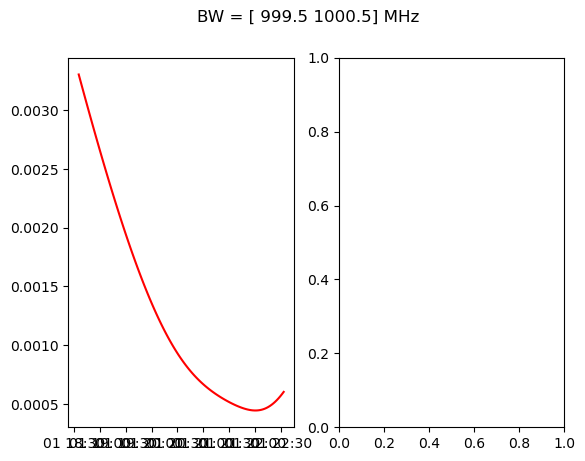

In [17]:
from skao_lib_simulator import RP1C_transit
input_dir = "skao_lib_simulator/spectral_ms"
for freq in freqs:
    gt_freq_name = os.path.join(input_dir, f"image_{freq:.2f}MHz.ms")
    RP1C_transit.main(gt_freq_name)

## 5. Usage

#### DDFacet tutorial

Requirements:
```bash
# install singularity
sudo apt update
sudo apt install singularity-container -y

#install ds9
sudo apt install saods9
```
Download @Cyril_Tasse singularity image: https://share.obspm.fr/s/rWJxnSfzGnt8S8D

```bash
#create a temp repository with the right
sudo mkdir -p /media/tasse/data
sudo chown -R $USER:$USER /media/tasse

```

Make sure than the `Template.parset` and the `0000.MS` are on the same lovcation than the singularity image:

```bash
# run the singularity environment
singularity shell -B/home -B/media/tasse/data ./ddf_dev_np1.22.4.sif

#run the ddfacet example
DDF.py Template.parset --Data-MS 0000.MS --Output-Mode Clean --Output-Name testSSD2 --Cache-Reset 1 --Facets-NFacets 3 --Deconv-Mode SSD2 --Freq-NBand 2 --Freq-NDegridBand 5 --Mask-External None --Mask-Auto 1 --Deconv-MaxMajorIter 5 --CF-wmax 1000 --Output-RestoringBeam 90 --Selection-AutoFlagNyquist 1
```

To open the generated images:

```bash
dsm.py testSSD2.dirty.fits
testSSD2.app.restored.fits

#or with ds9
ds9 *.fits -lock frame wcs -zoom to fit
```

---
#### check our models with ddfacet

```bash
# run the singularity environment
singularity shell -B/home -B/media/tasse/data ./ddf_dev_np1.22.4.sif

#run to convert vis from uv plan to vis grid
DDF.py --Data-MS SGRA.ms --Output-Mode Dirty --Output-Name testSSD2 --Cache-Reset 1 --Facets-NFacets 3 --Deconv-Mode SSD2 --Freq-NBand 2 --Freq-NDegridBand 5 --Mask-External None --Mask-Auto 1 --Deconv-MaxMajorIter 5 --CF-wmax 1000 --Output-RestoringBeam 90 --Selection-AutoFlagNyquist 1 --Image-Cell 1 --SSD2-PolyFreqOrder 1 --Data-ColName DATA 

#run to convert vis grid to vis on uv plan
DDF.py testSSD2.parset --Output-Mode Predict --Predict-FromImage testSSD2.dirty.fits --Predict-ColName DDF_PREDICT --Output-Name SGRA
```

---
## Comparing Visibilities quality

At the end we will be able to compare a fake "true sky" which is our input **FITS** image to reconstructed image which are the output of radio-astronomy imaging pipeline.

#### ✅ **RMSE (Root Mean Square Error)**  
- Compares the reconstructed image pixel by pixel with the reference image (the original).  
- The lower the RMS error, the more faithful the reconstructed image.  
 

#### ✅ **PSNR (Peak Signal-to-Noise Ratio)**  
- Indicates how much noise has been added by the algorithm.  
- The higher the **PSNR**, the better the reconstruction.   

#### ✅ **SSIM (Structural Similarity Index Measure)**  
- Measures **visual perception** by taking into account brightness, contrast and structure.  
- The closer **SSIM** is to **1**, the better the reconstruction.  

PSNR: 100 dB
RMS: 0.0
Taille de l'image FITS : (1, 512, 512)
SSIM: 1.0
Max Residual: 0.0


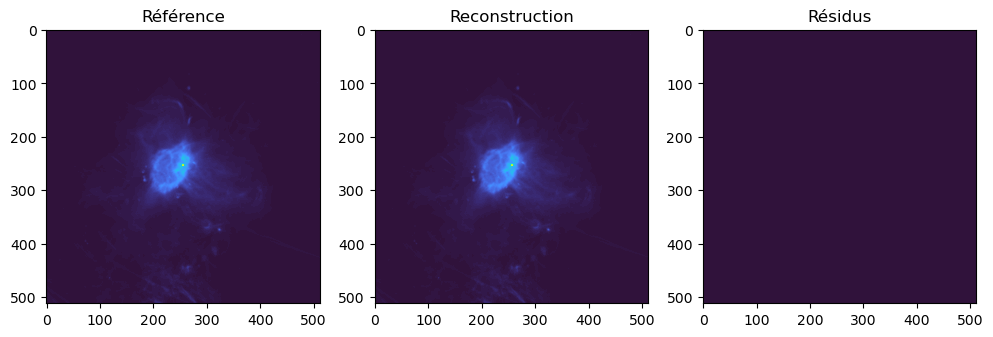

In [18]:
import numpy as np
import astropy.io.fits as fits
import cv2
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt

# Fonction pour charger une image FITS
def load_fits_image(file_path):
    with fits.open(file_path) as hdul:
        image_data = hdul[0].data
    return image_data

# Fonction pour calculer le PSNR (Peak Signal-to-Noise Ratio)
def psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return 100  # Pas d'erreur, les images sont identiques
    max_pixel = 255.0
    return 10 * log10((max_pixel ** 2) / mse)

# Fonction pour calculer le RMS (Root Mean Square Error)
def rms(original, reconstructed):
    return sqrt(np.mean((original - reconstructed) ** 2))

# Fonction pour calculer le SSIM (Structural Similarity Index)
def compute_ssim(original, reconstructed):

    image_data = original[0].data  # Extraire les données de l'image
    print("Taille de l'image FITS :", image_data.shape)    # Adjust win_size if necessary
   # Access the actual image data, assuming it's in the last two dimensions
    original_data = original[0, 0, :, :]
    reconstructed_data = reconstructed[0, 0, :, :]
    return ssim(original_data, reconstructed_data,data_range=original_data.max() - original_data.min())

# Fonction pour afficher les résultats
def compare_images(reference_image, reconstructed_image):
    # Calcul du PSNR
    psnr_value = psnr(reference_image, reconstructed_image)
    print(f"PSNR: {psnr_value} dB")

    # Calcul du RMS
    rms_value = rms(reference_image, reconstructed_image)
    print(f"RMS: {rms_value}")

    # Calcul du SSIM
    ssim_value = compute_ssim(reference_image, reconstructed_image)
    print(f"SSIM: {ssim_value}")

    # Affichage des résidus
    residual = reference_image - reconstructed_image
    print(f"Max Residual: {np.max(residual)}")

    # Optionnel: Afficher les images et les résidus
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))

    # Image de référence
    plt.subplot(1, 3, 1)
    plt.imshow(reference_image[0, 0, :, :], cmap='turbo')
    plt.title("Référence")

    # Image reconstruite
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_image[0, 0, :, :], cmap='turbo')
    plt.title("Reconstruction")

    # Résidus
    plt.subplot(1, 3, 3)
    plt.imshow(residual[0, 0, :, :], cmap='turbo')
    plt.title("Résidus")

    plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    reference_path = gt_name  # fits1
    reconstructed_path = gt_name  # fits2

    # Charger les images FITS
    reference_image = load_fits_image(reference_path)
    reconstructed_image = load_fits_image(reconstructed_path)

    # Assurer que les images sont de même taille
    if reference_image.shape != reconstructed_image.shape:
        print("Erreur : Les images ne sont pas de la même taille!")
    else:
        # Comparer les images
        compare_images(reference_image, reconstructed_image)

## References
📂 [ska-sdp-func-python git](https://gitlab.com/ska-telescope/sdp/ska-sdp-func-python)

📘 [ska-sdp-func-python doc](https://developer.skao.int/projects/ska-sdp-func-python/en/latest/)

📂 [ska-sdp-func-datamodels git](https://gitlab.com/ska-telescope/sdp/ska-sdp-datamodels)

📘 [ska-sdp-func-datamodels doc](https://developer.skao.int/projects/ska-sdp-datamodels/en/latest/)

📂 [rascil git](https://gitlab.com/ska-telescope/external/rascil-main)

📘 [rascil doc](https://developer.skao.int/projects/rascil/en/latest/index.html)

🔗 [CASA](https://casadocs.readthedocs.io/en/stable/notebooks/synthesis_imaging.html) --> section **Types of images** for the various spectral distribution
